Epoch 001 | Train Loss: 1355.5070 | Val Loss: 752.9637
Epoch 002 | Train Loss: 443.0175 | Val Loss: 137.3346
Epoch 003 | Train Loss: 140.4906 | Val Loss: 103.8945
Epoch 004 | Train Loss: 99.7654 | Val Loss: 102.6222
Epoch 005 | Train Loss: 81.6613 | Val Loss: 93.3984
Epoch 006 | Train Loss: 79.3201 | Val Loss: 88.0414
Epoch 007 | Train Loss: 71.7863 | Val Loss: 87.8829
Epoch 008 | Train Loss: 68.8613 | Val Loss: 85.1499
Epoch 009 | Train Loss: 66.2874 | Val Loss: 82.4681
Epoch 010 | Train Loss: 68.9780 | Val Loss: 84.0651
Epoch 011 | Train Loss: 65.8795 | Val Loss: 83.2225
Epoch 012 | Train Loss: 62.4444 | Val Loss: 83.6480
Epoch 013 | Train Loss: 80.3510 | Val Loss: 78.9469
Epoch 014 | Train Loss: 65.9696 | Val Loss: 78.6457
Epoch 015 | Train Loss: 81.9859 | Val Loss: 81.3747
Epoch 016 | Train Loss: 71.4984 | Val Loss: 89.8358
Epoch 017 | Train Loss: 61.4778 | Val Loss: 78.7959
Epoch 018 | Train Loss: 57.2917 | Val Loss: 79.3589
Epoch 019 | Train Loss: 62.9006 | Val Loss: 79.6732
Epoc

C:\Users\islam\AppData\Local\Temp\ipykernel_12620\3459556475.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_nn_model.pth"))


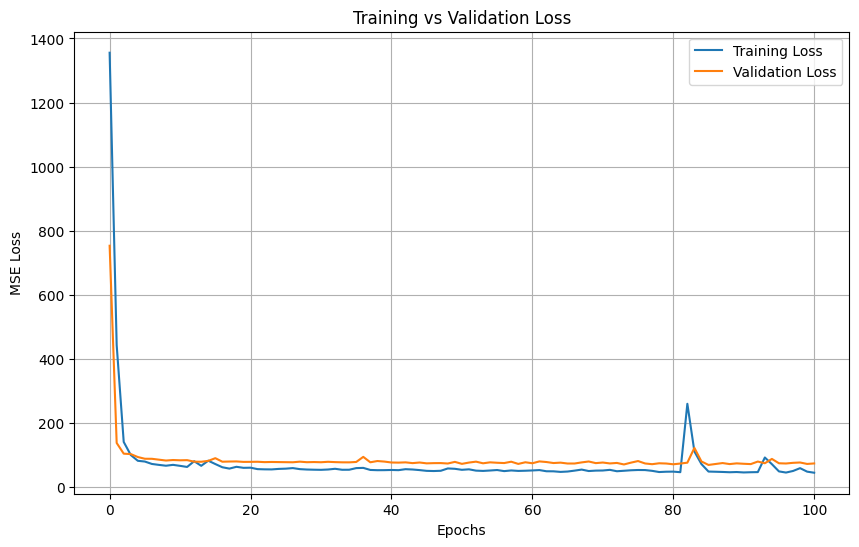

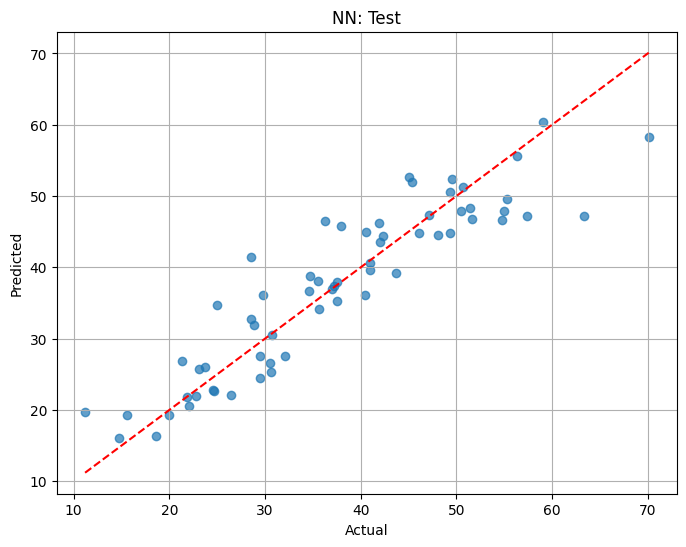


✔ Best Neural Network saved as best_nn_model.pth
✔ Training & evaluation completed successfully!


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = "cuda" if torch.cuda.is_available() else "cpu"


# 1. LOAD DATA
X_train = pd.read_csv("X_train_corr_filtered.csv").values
y_train = pd.read_csv("y_train.csv").iloc[:, 0].values

X_val = pd.read_csv("X_val_corr_filtered.csv").values
y_val = pd.read_csv("y_val.csv").iloc[:, 0].values

X_test = pd.read_csv("X_test_corr_filtered.csv").values
y_test = pd.read_csv("y_test.csv").iloc[:, 0].values

# Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

input_dim = X_train.shape[1]


# 2. MODEL

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.03)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = Net(input_dim).to(device)

# 3. TRAINING SETUP

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

epochs = 150
batch_size = 16
patience = 15

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val),
                        batch_size=batch_size, shuffle=False)


# 4. TRAINING WITH EARLY STOPPING

train_losses, val_losses = [], []
best_val_loss = float("inf")
counter = 0

for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    #  VALIDATION 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    #  EARLY STOPPING 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_nn_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("\n🛑 Early Stopping Triggered")
            break

# Load best model
model.load_state_dict(torch.load("best_nn_model.pth"))


# 5. PREDICTIONS

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).cpu().numpy().flatten()
    y_val_pred = model(X_val).cpu().numpy().flatten()
    y_test_pred = model(X_test).cpu().numpy().flatten()

y_train_true = y_train.cpu().numpy().flatten()
y_val_true = y_val.cpu().numpy().flatten()
y_test_true = y_test.cpu().numpy().flatten()


# 6. EVALUATION FUNCTION

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n===== {name} Evaluation =====")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")


evaluate(y_test_true, y_test_pred, "TEST")


# 7. LOSS CURVE

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# 8. PREDICTED vs ACTUAL

def plot_pred(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    min_v, max_v = min(y_true), max(y_true)
    plt.plot([min_v, max_v], [min_v, max_v], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()


plot_pred(y_test_true, y_test_pred, "NN: Test")


#  RESIDUALS (TEST)

# 10. SAVE MODEL
print("\n✔ Best Neural Network saved as best_nn_model.pth")
print("✔ Training & evaluation completed successfully!")
